(256, 256, 3)


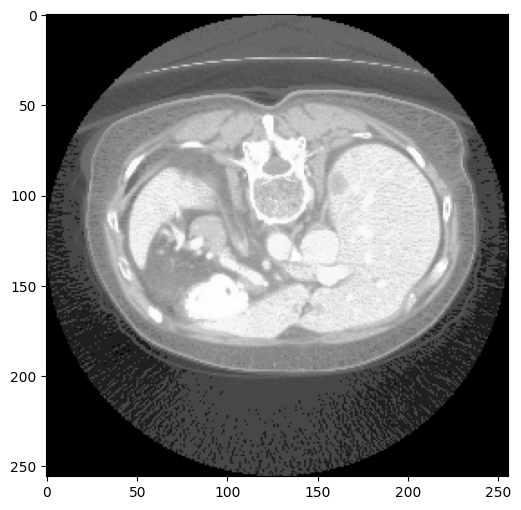

(256, 256, 3)


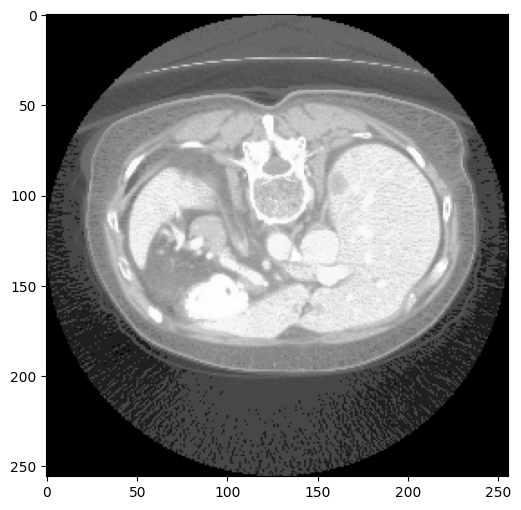

(256, 256, 3)


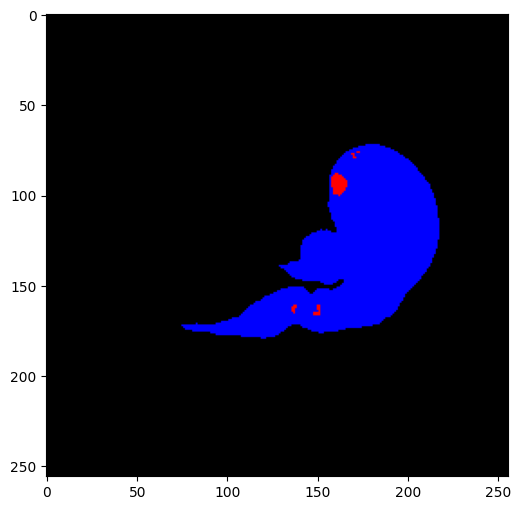

(256, 256, 3)


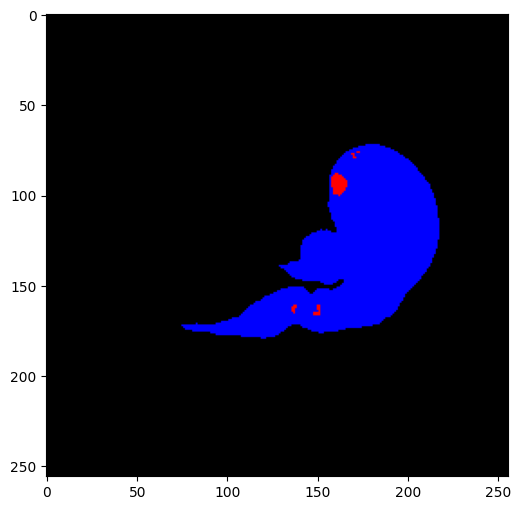

In [1]:
import mmcv
import mmengine
import matplotlib.pyplot as plt

general_path = "/home/budzynskaj/project/LiverCancerProject/data/d/dane"

path_old = general_path + "/volumes_norm_final/volume-0_58.png" 
path = general_path + "/volumes_norm_final/volume-0_58.png" 
path_label = general_path + "/volume_labels/volume-0_58.png" 
path_seg = general_path + "/volume_labels/segmentation-0_58.png" 

img = mmcv.imread(path_old)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

img = mmcv.imread(path)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

img = mmcv.imread(path_label)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

img = mmcv.imread(path_seg)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [2]:
data_root = general_path
img_dir = 'volumes_norm_final'
ann_dir = 'volume_labels'

# define class and palette for better visualization
classes = ('other', 'liver', 'lesion')
palette = [[0, 0, 0], [0, 0, 255], [255, 0, 0]]

In [3]:
# ZROBIĆ TYLKO RAZ I ZOSTAWIĆ ZAKOMENTOWANE, ŻEBY NIE TRACIC CZASU :)))
# JEST W PLIKU NA DYSKU WSZYSTKO

import os
import os.path as osp
import numpy as np
from PIL import Image

'''# convert dataset annotation to semantic segmentation map
for file in mmengine.scandir(osp.join(data_root, ann_dir)):
     if "segmentation" in file:
         seg_img = Image.open(osp.join(data_root, ann_dir, file)).convert('P')
         seg_img.putpalette(np.array(palette, dtype=np.uint8))
         seg_img.save(osp.join(data_root, ann_dir, file.replace('segmentation', 
                                                             'volume')))'''

'# convert dataset annotation to semantic segmentation map\nfor file in mmengine.scandir(osp.join(data_root, ann_dir)):\n     if "segmentation" in file:\n         seg_img = Image.open(osp.join(data_root, ann_dir, file)).convert(\'P\')\n         seg_img.putpalette(np.array(palette, dtype=np.uint8))\n         seg_img.save(osp.join(data_root, ann_dir, file.replace(\'segmentation\', \n                                                             \'volume\')))'

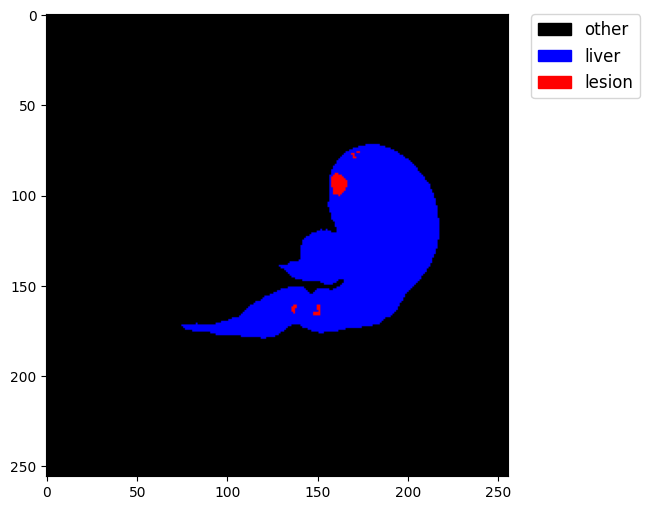

In [4]:
# Let's take a look at the segmentation map we got
import os
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches

img = Image.open(path_label)
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [5]:
# split train/val/test set randomly
# w plikach splits wszystko powinno być zapisane jako volume

split_dir = 'splits/ocrnet-aug'
split_file = 'volume'

mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png') if split_file in filename]

with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 70/100 as train set
    train_length = int(len(filename_list)*70/100)
    f.writelines(line + '\n' for line in filename_list[:train_length])

with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select next 15/100 as val set
    val_length = int(len(filename_list)*85/100)
    f.writelines(line + '\n' for line in filename_list[train_length:val_length])
    
with open(osp.join(data_root, split_dir, 'test.txt'), 'w') as f:
    # select last 15/100 as test set
    f.writelines(line + '\n' for line in filename_list[val_length:])

In [6]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class LiverCancerDataset(BaseSegDataset):
    METAINFO = dict(classes = classes, palette = palette)
    def __init__(self, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [7]:
from mmengine import Config

general_path2 = "/home/budzynskaj/mmsegmentation/configs/"
# cfg = Config.fromfile(general_path2 + '/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
# cfg = Config.fromfile(general_path2 + '/unet/unet-s5-d16_fcn_4xb4-160k_cityscapes-512x1024.py')
cfg = Config.fromfile(general_path2 + 'ocrnet/ocrnet_r101-d8_8xb2-80k_cityscapes-512x1024.py')


print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/cityscapes/'
dataset_type = 'CityscapesDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=8000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

In [9]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', device='cpu')
cfg.crop_size = (256, 256)
cfg.workers_per_gpu = 0

cfg.optimizer.type = 'AdamW'

cfg.model.data_preprocessor.size = cfg.crop_size


# Modify dataset type and path
cfg.dataset_type = 'LiverCancerDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomResize', scale=(256, 256), ratio_range=(1.0, 1.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),  # Augmentation pipeline that distort current image with several photo metric methods.
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    # dict(type='Resize', scale=(320, 240), keep_ratio=True),
    dict(type='Resize', scale=(256, 256), keep_ratio=True),
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/ocrnet-aug/train.txt'

# IMPORTANT
cfg.train_dataloader.num_workers = 0
cfg.train_dataloader.persistent_workers = False

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/ocrnet-aug/val.txt'

# IMPORTANT
cfg.val_dataloader.num_workers = 0
cfg.val_dataloader.persistent_workers = False

cfg.test_dataloader = cfg.val_dataloader
cfg.test_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.ann_file = 'splits/ocrnet-aug/test.txt'
cfg.test_evaluator = dict(type='IoUMetric', iou_metrics=['mIoU', 'mDice', 'mFscore'])

# TUTAJ TRZEBA WSTAWIĆ PLIK PATH Z ITERACJI Z KTOREJ CHCEMY WYKORZYSTAC MODEL
cfg.load_from = '/home/budzynskaj/project/LiverCancerProject/data/d/dane/workdirs/ocrnet-aug/iter_32000.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/home/budzynskaj/project/LiverCancerProject/data/d/dane/test_results/ocrnet-aug'

# cfg.train_cfg.max_iters = 600
cfg.train_cfg.val_interval = 2000
cfg.default_hooks.logger.interval = 100
cfg.default_hooks.checkpoint.interval = 1000

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = '/home/budzynskaj/project/LiverCancerProject/data/d/dane'
dataset_type = 'LiverCancerDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=1000, type='CheckpointHook'),
    logger=dict(interval=100, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    

In [10]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

05/21 16:55:46 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.19 (default, Mar 20 2024, 19:58:24) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 2080 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.3, V12.3.107
    GCC: gcc (SUSE Linux) 7.5.0
    PyTorch: 2.0.0+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute

/home/budzynskaj/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/budzynskaj/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


05/21 16:55:48 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
05/21 16:55:48 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/budzynskaj/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [11]:
# start training
runner.test()

05/21 16:55:50 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by local backend from path: /home/budzynskaj/project/LiverCancerProject/data/d/dane/workdirs/ocrnet-aug/iter_32000.pth
05/21 16:55:50 - mmengine - INFO - Load checkpoint from /home/budzynskaj/project/LiverCancerProject/data/d/dane/workdirs/ocrnet-aug/iter_32000.pth
05/21 16:55:54 - mmengine - INFO - Iter(test) [ 100/8796]    eta: 0:04:44  time: 0.0183  data_time: 0.0017  memory: 8962  
05/21 16:55:55 - mmengine - INFO - Iter(test) [ 200/8796]    eta: 0:03:38  time: 0.0188  data_time: 0.0018  memory: 343  
05/21 16:55:57 - mmengine - INFO - Iter(test) [ 300/8796]    eta: 0:03:11  time: 0.0171  data_time: 0.0013  memory: 343  
05/21 16:55:59 - mmengine - INFO - Iter(test) [ 400/8796]    eta: 0:02:56  time: 0.0167  data_time: 0.0012  memory: 343  
05/21 16:56:00 - mmengine - INFO - Iter(test) [ 500/8796]    eta: 0:02:47  time: 0.0167  data_time: 0.0012  memory: 343  
05/21 16:56:02 - mm

{'aAcc': 99.76,
 'mIoU': 81.24,
 'mAcc': 90.49,
 'mDice': 88.37,
 'mFscore': 88.37,
 'mPrecision': 86.49,
 'mRecall': 90.49}

/home/budzynskaj/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /home/budzynskaj/project/LiverCancerProject/data/d/dane/workdirs/ocrnet-aug/iter_32000.pth


/home/budzynskaj/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


(256, 256, 3)


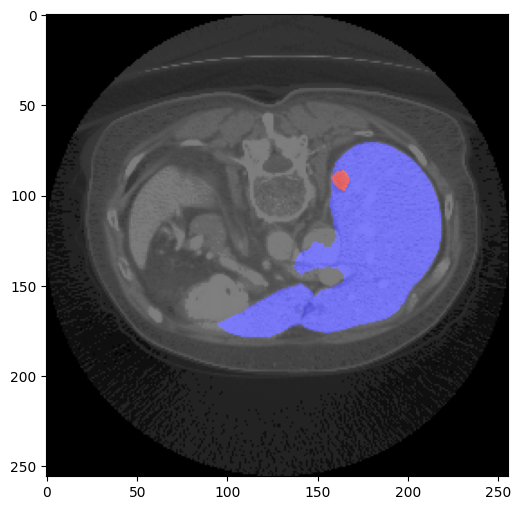

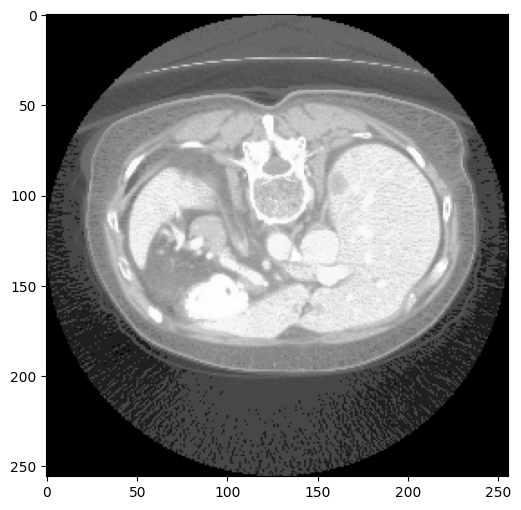

(256, 256, 3)


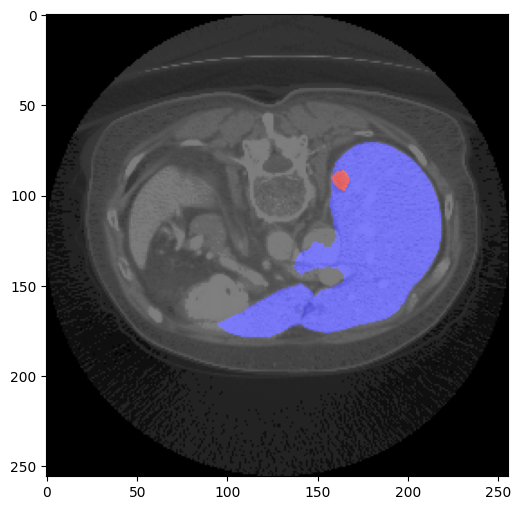

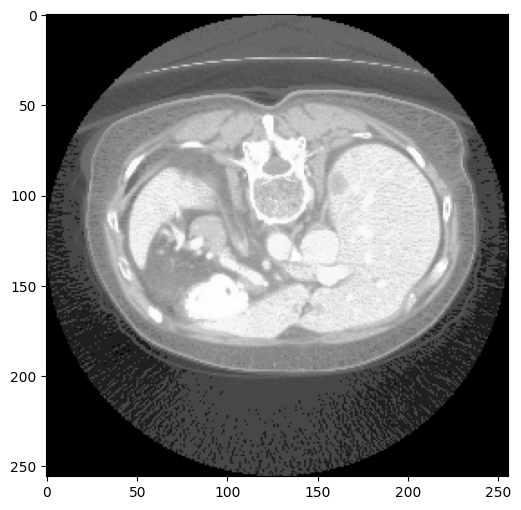

(256, 256, 3)


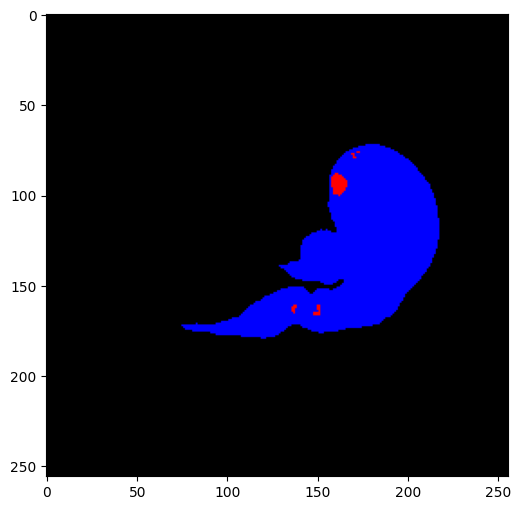

(256, 256, 3)


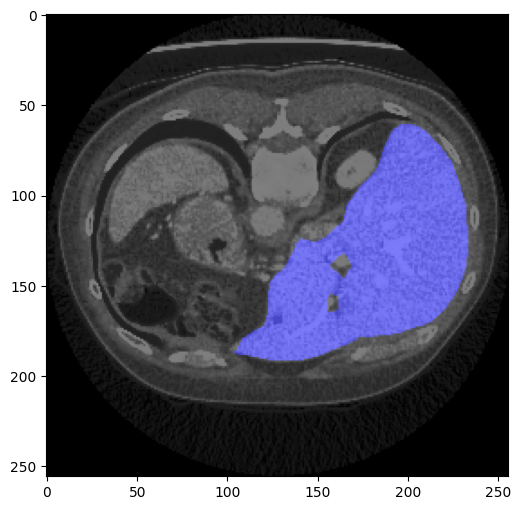

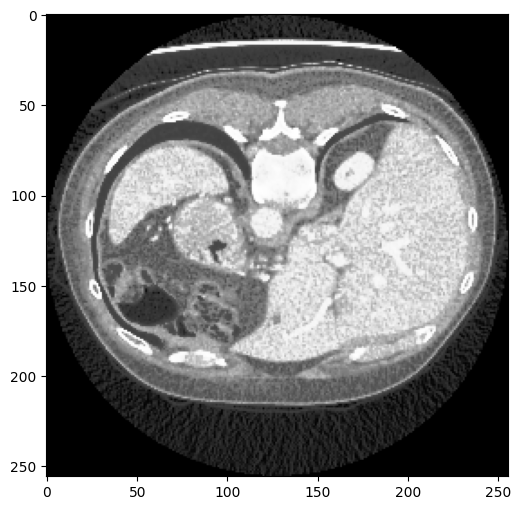

(256, 256, 3)


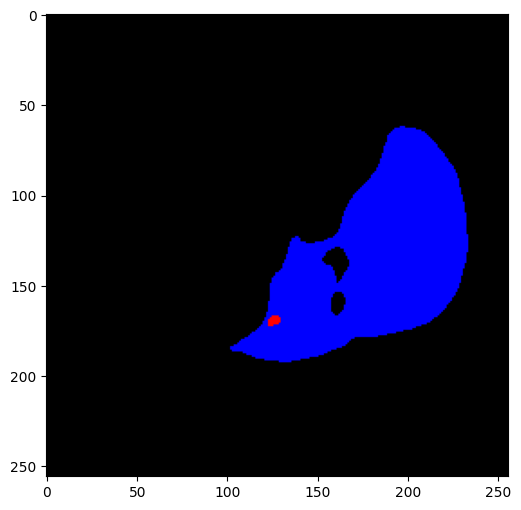

In [12]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = '/home/budzynskaj/project/LiverCancerProject/data/d/dane/workdirs/ocrnet-aug/iter_32000.pth'
config = '/home/budzynskaj/project/LiverCancerProject/data/d/dane/test_results/resnest/20240507_165148/vis_data/config.py'

model = init_model(cfg, checkpoint_path, 'cuda:0')


general_path = "/home/budzynskaj/project/LiverCancerProject/data/d/dane"

path_old = general_path + "/volumes_norm_final/volume-0_58.png" 
path = general_path + "/volumes_norm_final/volume-0_58.png" 
path_label = general_path + "/volume_labels/volume-0_58.png" 
path_seg = general_path + "/volume_labels/segmentation-0_58.png" 

img = mmcv.imread(path)
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result, with_labels=False)
plt.imshow(vis_result)


img = mmcv.imread(path)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

img = mmcv.imread(path_old)
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result, with_labels=False)
plt.imshow(vis_result)


img = mmcv.imread(path_old)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()


img = mmcv.imread(path_label)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

path = general_path + "/volumes_norm_final/volume-92_466.png" 
path_label = general_path + "/volume_labels/volume-92_466.png" 

img = mmcv.imread(path)
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result, with_labels=False)
plt.imshow(vis_result)


img = mmcv.imread(path)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()


img = mmcv.imread(path_label)
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [13]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib

# Define path to data and results folders
data_dir = '/home/budzynskaj/project/LiverCancerProject/data/d/dane/volumes_norm_final'
results_dir = '/home/budzynskaj/project/LiverCancerProject/data/d/dane/results/ocrnet-aug-32000'  # Folder to save segmentation results
config = '/home/budzynskaj/project/LiverCancerProject/data/d/dane/test_results/upernet/20240512_160410/vis_data/config.py'

# Init the model from the config and the checkpoint
checkpoint_path = '/home/budzynskaj/project/LiverCancerProject/data/d/dane/workdirs/ocrnet-aug/iter_32000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

path = data_dir + "/volume-90_350.png"

# Target RGB values for blue (no tolerance)
blue_threshold = [0, 0, 255]

with open("/home/budzynskaj/project/LiverCancerProject/data/d/dane/splits/ocrnet-aug/test.txt", "r") as f:
    filenames_to_save = f.readlines()
    filenames_to_save = [line.strip() + ".png" for line in filenames_to_save]

    print(filenames_to_save)

    # Loop through the first 10 images in the data directory
    number_of_saved_images = 0  # Initialize counter for saved images
    for i, filename in enumerate(os.listdir(data_dir)):

        if filename in filenames_to_save:
            # Read the image
            img_path = os.path.join(data_dir, filename)
            img = mmcv.imread(img_path)

            # Perform inference
            result = inference_model(model, img)

            # Check for presence of exact blue color
            vis_result = show_result_pyplot(model, img, result, with_labels=False, opacity=1)  # Assuming visualization needed
            vis_result_rgb = vis_result.astype(np.uint8)
            unique_colors = np.unique(vis_result_rgb.reshape(-1, 3), axis=0)
            is_blue_present = False
            for color in unique_colors:
                if np.all(color == blue_threshold):  # Check for exact match
                    is_blue_present = True
                    break

            # Save image only if exact blue is present
            if is_blue_present:
                # Rest of the code for saving the image remains unchanged
                if not os.path.exists(results_dir):
                    os.makedirs(results_dir)

                save_path = os.path.join(results_dir, f'{filename[:-4]}_seg.png')
                mmcv.imwrite(vis_result, save_path)
                number_of_saved_images += 1  # Update counter

# Print the total number of saved images
print(f'Total images with exact blue color saved: {number_of_saved_images}')


Loads checkpoint by local backend from path: /home/budzynskaj/project/LiverCancerProject/data/d/dane/workdirs/ocrnet-aug/iter_32000.pth
['volume-89_566.png', 'volume-89_567.png', 'volume-89_568.png', 'volume-89_569.png', 'volume-89_57.png', 'volume-89_570.png', 'volume-89_571.png', 'volume-89_572.png', 'volume-89_573.png', 'volume-89_574.png', 'volume-89_575.png', 'volume-89_576.png', 'volume-89_577.png', 'volume-89_578.png', 'volume-89_579.png', 'volume-89_58.png', 'volume-89_580.png', 'volume-89_581.png', 'volume-89_582.png', 'volume-89_583.png', 'volume-89_584.png', 'volume-89_585.png', 'volume-89_586.png', 'volume-89_587.png', 'volume-89_588.png', 'volume-89_589.png', 'volume-89_59.png', 'volume-89_590.png', 'volume-89_591.png', 'volume-89_592.png', 'volume-89_593.png', 'volume-89_594.png', 'volume-89_595.png', 'volume-89_596.png', 'volume-89_597.png', 'volume-89_598.png', 'volume-89_599.png', 'volume-89_6.png', 'volume-89_60.png', 'volume-89_600.png', 'volume-89_601.png', 'volume-